In [1]:
import os
import glob
import numpy as np
import sklearn
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_raster
from skimage.exposure import rescale_intensity
import pickle
from functools import partial

from matplotlib import pyplot as plt
import time
from tqdm.notebook import tqdm
# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from dask.distributed import Client, progress

In [2]:
from src.utils.load import load_features
from src.utils.utils import colorize_dynamic_world

In [3]:
# create a hub to control the workers
c = Client()

In [4]:
YEAR = 2022
STATE = "oregon"

In [5]:
TILES = f'../data/interim/{STATE}_quarter_quads.shp'
tiles = gpd.read_file(TILES)
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7508 entries, 0 to 7507
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CELL_ID     7508 non-null   int64   
 1   CELL_NAME   7508 non-null   object  
 2   PRIMARY_ST  7508 non-null   object  
 3   CELL_MAPCO  7508 non-null   object  
 4   CELL_TYPE   7508 non-null   int64   
 5   CELL_ALLWA  7508 non-null   int64   
 6   CELL_DESCR  0 non-null      object  
 7   CELL_DIACR  0 non-null      object  
 8   GLOBALID    7508 non-null   object  
 9   SHAPE_Leng  7508 non-null   float64 
 10  SHAPE_Area  7508 non-null   float64 
 11  geometry    7508 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 704.0+ KB


In [6]:
MODEL = '../models/structure_models/production/global-sentinel-HistGradientBoostingRegressor-multioutput.pkl'
model = pickle.load(open(MODEL, 'rb'))

In [7]:
BAND_DESCRIPTIONS = {
    1: 'Canopy Cover',
    2: 'Dominant Height', 
    3: 'Live Tree Basal Area',
    4: 'Quadratic Mean Diameter',
    5: 'Trees Per Acre (Growing Stock)',
    6: 'Aboveground Live Tree Biomass',
    7: 'Dynamic World Land Cover'
}
BAND_UNITS = {
    1: 'Percent',
    2: 'Feet', 
    3: 'Square feet per acre',
    4: 'Inches',
    5: 'Trees Per Acre',
    6: '',
    7: '',
}

In [8]:
def load_predict(cell_id, year, state, overwrite=False):
    dwfile = f'../data/interim/{state}_imagery/dynamic_world/{cell_id}_dynamicworld{year}.tif'
    X = load_features(f'../data/interim/{state}_imagery', cell_id, year)

    with rasterio.open(f'../data/interim/{state}_imagery/sentinel/{cell_id}_sentinel{year}.tif') as src:
        profile = src.profile
        height, width = profile['height'], profile['width']
    # check for nodata in input dataframe
    pred = model.predict(X)
    for i in range(pred.shape[1]):
        if i == 0:
            pred[:,i] = np.clip(pred[:,i], 0, 100) # clip canopy cover to 0-100
        else:
            pred[:,i] = np.clip(pred[:,i], 0, None) # clip negative structure values
    pred = pred.reshape((height, width, 6))

    with rasterio.open(dwfile) as dw_src:
        dw = dw_src.read(1)
    
    profile.update(nodata=-9999, count=7, dtype='int16')
    
    pred[:][~np.isin(dw, [1,5])] = profile['nodata']

    pred_ras = reshape_as_raster(pred).astype('int16')

    return np.vstack((pred_ras, dw.reshape(1, height, width))), profile

In [9]:
def load_predict_save(cell_id, year, state, overwrite=False):
    outfile = f'../data/processed/{state}/predictions/{cell_id}_structure{year}.tif'
    if not os.path.exists(outfile) or overwrite:
        try:
            pred_ras, profile = load_predict(cell_id, year, state)

            with rasterio.open(outfile, 'w', **profile) as dst:
                for i in range(profile['count']):
                    dst.write(pred_ras[i], i+1)
                    dst.set_band_description(i+1, BAND_DESCRIPTIONS[i+1])
                    dst.set_band_unit(i+1, BAND_UNITS[i+1])

        except Exception as e:
            print("Failed on", cell_id, e)
    return cell_id

In [10]:
to_run = [os.path.basename(f).split("_")[0] for f in glob.glob(f'../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif')]

In [11]:
os.makedirs(f'../data/processed/{STATE}/predictions/', exist_ok=True)

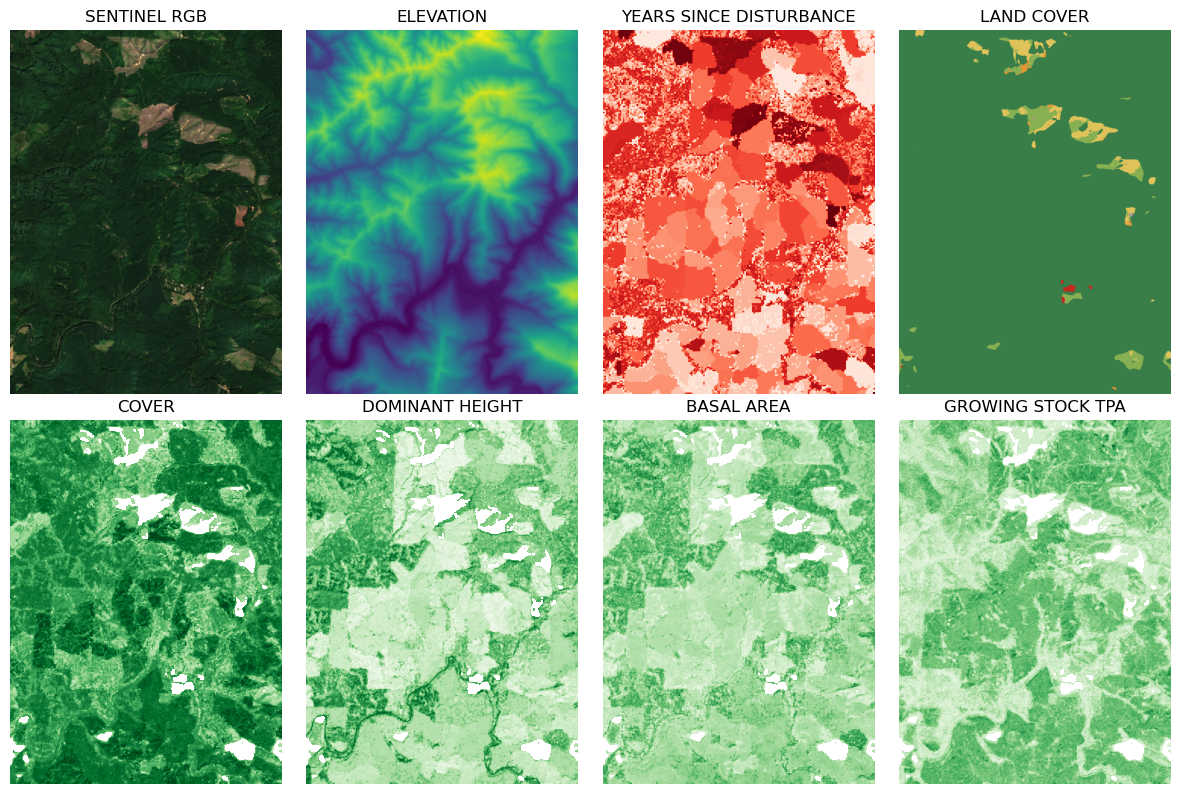

In [12]:
CELL_ID = 169581 # Golden Falls NW # Elliott State Forest with a couple clearcuts
    
pred, prof = load_predict(CELL_ID, YEAR, STATE)
pred = np.ma.masked_values(pred, -9999)

with rasterio.open(f'../data/interim/{STATE}_imagery/sentinel/{CELL_ID}_sentinel{YEAR}.tif') as src:
    height, width = src.height, src.width
    img = src.read()
    profile = src.profile
    
with rasterio.open(f'../data/interim/{STATE}_imagery/landtrendr/{CELL_ID}_landtrendr{YEAR}.tif') as src:
    lt_height, lt_width = src.height, src.width
    lt_ysd = src.read(1)
    lt_profile = src.profile
    
with rasterio.open(f'../data/interim/{STATE}_imagery/dem/{CELL_ID}_dem.tif') as src:
    dem_height, dem_width = src.height, src.width
    dem = src.read(1)
    dem_profile = src.profile
    
fig, axs = plt.subplots(2,4, figsize=(12,8))
axs.ravel()[0].imshow(rescale_intensity(
    np.dstack((img[2], img[1], img[0])), 
    in_range=(0,2000),
    out_range='uint8').astype('uint8'))

axs.ravel()[1].imshow(dem, cmap='viridis')
axs.ravel()[2].imshow(lt_ysd, cmap='Reds_r', vmin=0, vmax=40)
axs.ravel()[3].imshow(colorize_dynamic_world(pred[-1]))
TITLES = ['SENTINEL RGB', 'ELEVATION', 'YEARS SINCE DISTURBANCE', 'LAND COVER', 
          'COVER', 'DOMINANT HEIGHT', 'BASAL AREA', 'GROWING STOCK TPA']
for j, band_num in enumerate([0, 1, 2, 4]):
    axs[1, j].imshow(pred[band_num]/pred[band_num].max(), cmap='Greens')
for i, ax in enumerate(axs.ravel()):
    axs.ravel()[i].set_title(TITLES[i])
    axs.ravel()[i].axis('off')


plt.tight_layout()
plt.savefig('../reports/figures/prediction_example_elliott.png', dpi=300)
plt.show()    

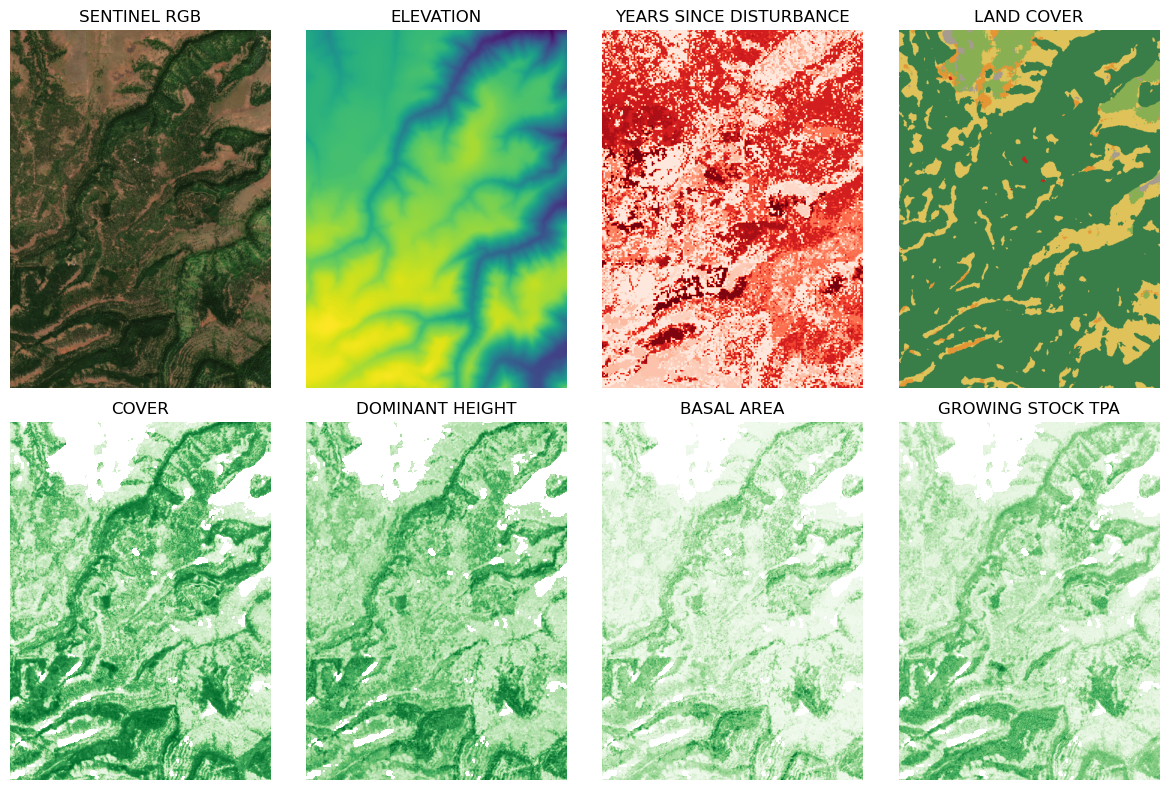

In [13]:
CELL_ID = 191184 # Kinney Lake SE # NE Oregon
    
pred, prof = load_predict(CELL_ID, YEAR, STATE)
pred = np.ma.masked_values(pred, -9999)

with rasterio.open(f'../data/interim/{STATE}_imagery/sentinel/{CELL_ID}_sentinel{YEAR}.tif') as src:
    height, width = src.height, src.width
    img = src.read()
    profile = src.profile
    
with rasterio.open(f'../data/interim/{STATE}_imagery/landtrendr/{CELL_ID}_landtrendr{YEAR}.tif') as src:
    lt_height, lt_width = src.height, src.width
    lt_ysd = src.read(1)
    lt_profile = src.profile
    
with rasterio.open(f'../data/interim/{STATE}_imagery/dem/{CELL_ID}_dem.tif') as src:
    dem_height, dem_width = src.height, src.width
    dem = src.read(1)
    dem_profile = src.profile
    
fig, axs = plt.subplots(2,4, figsize=(12,8))
axs.ravel()[0].imshow(rescale_intensity(
    np.dstack((img[2], img[1], img[0])), 
    in_range=(0,2000),
    out_range='uint8').astype('uint8'))

axs.ravel()[1].imshow(dem, cmap='viridis')
axs.ravel()[2].imshow(lt_ysd, cmap='Reds_r', vmin=0, vmax=40)
axs.ravel()[3].imshow(colorize_dynamic_world(pred[-1]))
TITLES = ['SENTINEL RGB', 'ELEVATION', 'YEARS SINCE DISTURBANCE', 'LAND COVER', 
          'COVER', 'DOMINANT HEIGHT', 'BASAL AREA', 'GROWING STOCK TPA']
for j, band_num in enumerate([0, 1, 2, 4]):
    axs[1, j].imshow(pred[band_num]/pred[band_num].max(), cmap='Greens')
for i, ax in enumerate(axs.ravel()):
    axs.ravel()[i].set_title(TITLES[i])
    axs.ravel()[i].axis('off')


plt.tight_layout()
plt.savefig('../reports/figures/prediction_example_kinneylake.png', dpi=300)
plt.show()    

In [14]:
pred.max(axis=(1,2)).data, pred.mean(axis=(1,2)).data, pred.min(axis=(1,2)).data

(array([ 90, 118, 333,  25, 349, 107,   7], dtype=int16),
 array([ 45.21667622,  60.64440766,  75.47978389,  11.16232533,
        106.96577648,  20.45658126,   1.91129136]),
 array([ 7, 16,  0,  4,  0,  0,  1], dtype=int16))

In [15]:
can_run = [os.path.basename(f).split("_")[0] for f in glob.glob(f'../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif')]
already_run = [os.path.basename(f).split("_")[0] for f in glob.glob(f'../data/processed/{STATE}/predictions/*')]
to_run = [x for x in can_run if x not in already_run]

In [16]:
# to_run = np.unique(tiles.CELL_ID.values)

In [17]:
# with tqdm(total=len(to_run)) as pbar:
#     completed = []
#     with ThreadPoolExecutor(4) as executor: # 12 mins for 130 predictions
#         # with parallel_backend('loky', n_jobs=1):
#         jobs = [executor.submit(load_predict_save, cell_id, YEAR, STATE) for cell_id in to_run]
#         for job in as_completed(jobs):
#             completed.append(job.result())
#             pbar.update()

In [18]:
# start batch
run_model = partial(load_predict_save, year=YEAR, state=STATE)

In [19]:
res = c.map(run_model, to_run)
print('Started batch processing.')

Started batch processing.


In [20]:
with tqdm(total=len(can_run), smoothing=0.7) as pbar:
    finished = len(glob.glob(f'../data/processed/{STATE}/predictions/*.tif'))
    pbar.update(finished)
    while finished < len(can_run):
        now = len(glob.glob(f'../data/processed/{STATE}/predictions/*.tif'))
        pbar.update(now - finished)
        finished = now
        time.sleep(0.1)

  0%|          | 0/7508 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# c.close()

In [ ]:
# c.cancel(res)